In [4]:
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from elosports.elo import Elo
import time
import matplotlib.pyplot as plt



In [5]:
PL_21_team_ratings = pd.read_csv('PL21_teamratings.csv')
PL_21_team_ratings


,Div,Date_x,Time_x,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Rating difference,form5GamesH,form5GamesA,form5GamesDifference,eloH,eloA,eloDifference,pointsH,pointsA,pointsDifference
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,-6.272727,0,0,0,1500.000000,1500.000000,0.000000,0,0,0
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,0.151515,0,0,0,1500.000000,1500.000000,0.000000,0,0,0
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,10.606061,0,0,0,1500.000000,1500.000000,0.000000,0,0,0
3,E0,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,0,0,...,-1.969697,0,0,0,1500.000000,1500.000000,0.000000,0,0,0
4,E0,2020-09-13,14:00,West Brom,Leicester City,0,3,A,0,0,...,-6.432765,0,0,0,1500.000000,1500.000000,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,7.121212,13,6,7,1572.195622,1458.109252,114.086370,66,44,22
376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,3.090909,9,9,0,1629.646004,1521.033816,108.612188,83,59,24
377,E0,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,1,0,...,-0.231183,6,6,0,1362.194200,1452.510491,-90.316291,20,39,-19
378,E0,2021-05-23,16:00,West Ham,Southampton,3,0,H,2,0,...,0.000000,7,4,3,1551.974233,1441.808453,110.165781,62,43,19


In [122]:
def get_points(team, wk):
    for index, row in PL_21_team_ratings.iterrows():
        #print(row[['HomeTeam','Wk']])
        if row['Wk'] == wk and row['HomeTeam'] == team:
            if row['FTR'] == 'H':
                return 3
            elif row['FTR'] == 'D':
                return 1
            else: return 0
        if row['Wk'] == wk and row['AwayTeam'] == team:
            if row['FTR'] == 'A':
                return 3
            elif row['FTR'] == 'D':
                return 1
            else: return 0

def get_points_season(team, fr, to):
    out = 0
    for i in range(fr,to):
        out = out + get_points(team, i)
    return out

def get_ewm_season(team, fr, to):
    test = []
    out = 0
    df2 = pd.Series(test)
    if fr == to: return 0
    for i in range(fr,to):
        out = out + get_points(team, i)
        test.append(out)
        df=pd.Series(test)
        df2 = df.ewm(span=10).mean()[len(df)-1]
    #print(df2.dtype)
#    if df2.empty: return 0
    return df2


def append_form(timespan):
    formH = []
    formA = []
    for index, row in PL_21_team_ratings.iterrows():
        wk = row['Wk']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk) - timespan < 1:
            pointsH = get_points_season(teamH, 1, int(wk))
            pointsA = get_points_season(teamA, 1, int(wk))
        else:
            pointsH = get_points_season(teamH, int(wk)-timespan, int(wk))
            pointsA = get_points_season(teamA, int(wk)-timespan, int(wk))
        formH.append(pointsH)
        formA.append(pointsA)
    PL_21_team_ratings['pointsH'] = formH
    PL_21_team_ratings['pointsA'] = formA

def append_ewm(timespan):
    formH = []
    formA = []
    for index, row in PL_21_team_ratings.iterrows():
        wk = row['Wk']
        teamH = row['HomeTeam']
        teamA = row['AwayTeam']
        if int(wk) - timespan < 1:
            pointsH = get_ewm_season(teamH, 1, int(wk))
            pointsA = get_ewm_season(teamA, 1, int(wk))
        else:
            pointsH = get_ewm_season(teamH, int(wk)-timespan, int(wk))
            pointsA = get_ewm_season(teamA, int(wk)-timespan, int(wk))
        formH.append(pointsH)
        formA.append(pointsA)
    PL_21_team_ratings['ewmH'] = formH
    PL_21_team_ratings['ewmA'] = formA

#get_ewm_season('Liverpool', 1, 3)
#print(get_ewm_season('Liverpool', 1, 1))

#for i in range(1,20):
#    print( get_ewm_season('Liverpool',1,i))
append_ewm(39)
#PL_21_team_ratings






C:\Users\giuli\AppData\Local\Temp\ipykernel_69268\1647510357.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2 = pd.Series(test)


In [124]:
PL_21_team_ratings['ewmDifference'] = PL_21_team_ratings['ewmH'] - PL_21_team_ratings['ewmA']
PL_21_team_ratings

,Div,Date_x,Time_x,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,form5GamesDifference,eloH,eloA,eloDifference,pointsH,pointsA,pointsDifference,ewmH,ewmA,ewmDifference
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
3,E0,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,0,0,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
4,E0,2020-09-13,14:00,West Brom,Leicester City,0,3,A,0,0,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,7,1572.195622,1458.109252,114.086370,66,44,22,55.583420,38.955230,16.628190
376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,0,1629.646004,1521.033816,108.612188,83,59,24,74.762554,51.714922,23.047631
377,E0,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,1,0,...,0,1362.194200,1452.510491,-90.316291,20,39,-19,16.142893,35.046032,-18.903139
378,E0,2021-05-23,16:00,West Ham,Southampton,3,0,H,2,0,...,3,1551.974233,1441.808453,110.165781,62,43,19,54.832741,38.529670,16.303071


In [418]:
eloLeague = Elo(k = 20)
eloLeague.addPlayer("Arsenal", rating = 1500)
eloLeague.addPlayer("Aston Villa", rating = 1500)
eloLeague.addPlayer("Brighton", rating = 1500)
eloLeague.addPlayer("Burnley", rating = 1500)
eloLeague.addPlayer("Chelsea", rating = 1500)
eloLeague.addPlayer("Crystal Palace", rating = 1500)
eloLeague.addPlayer("Everton", rating = 1500)
eloLeague.addPlayer("Fulham", rating = 1500)
eloLeague.addPlayer("Leeds United", rating = 1500)
eloLeague.addPlayer("Leicester City", rating = 1500)
eloLeague.addPlayer("Liverpool", rating = 1500)
eloLeague.addPlayer("Manchester City", rating = 1500)
eloLeague.addPlayer("Manchester Utd", rating = 1500)
eloLeague.addPlayer("Newcastle Utd", rating = 1500)
eloLeague.addPlayer("Sheffield Utd", rating = 1500)
eloLeague.addPlayer("Southampton", rating = 1500)
eloLeague.addPlayer("Tottenham", rating = 1500)
eloLeague.addPlayer("West Brom", rating = 1500)
eloLeague.addPlayer("West Ham", rating = 1500)
eloLeague.addPlayer("Wolves", rating = 1500)
def calculate_elo():
    eloH = []
    eloA = []
    for index, row in PL_21_team_ratings.iterrows():
        eloH.append(eloLeague.ratingDict.get(row['HomeTeam']))
        eloA.append(eloLeague.ratingDict.get(row['AwayTeam']))
        if row['FTR'] == 'H':
            eloLeague.gameOver(winner= row['HomeTeam'], loser=row['AwayTeam'], winnerHome=True)
        elif row['FTR'] == 'A':
            eloLeague.gameOver(winner=row['AwayTeam'], loser=row['HomeTeam'], winnerHome=False)
    PL_21_team_ratings['eloH'] = eloH
    PL_21_team_ratings['eloA'] = eloA
calculate_elo()
PL_21_team_ratings




,Div,Date_x,Time_x,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Venue,Referee_y,Match Report,Notes,Rating difference,form5GamesH,form5GamesA,form5GamesDifference,eloH,eloA
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,Craven Cottage,Chris Kavanagh,Match Report,NaN,-6.272727,0,0,0,1500.000000,1500.000000
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,Selhurst Park,Jonathan Moss,Match Report,NaN,0.151515,0,0,0,1500.000000,1500.000000
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,Anfield,Michael Oliver,Match Report,NaN,10.606061,0,0,0,1500.000000,1500.000000
3,E0,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,0,0,...,London Stadium,Stuart Attwell,Match Report,NaN,-1.969697,0,0,0,1500.000000,1500.000000
4,E0,2020-09-13,14:00,West Brom,Leicester City,0,3,A,0,0,...,The Hawthorns,Anthony Taylor,Match Report,NaN,-6.432765,0,0,0,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,Anfield,Craig Pawson,Match Report,NaN,7.121212,13,6,7,1572.195622,1458.109252
376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,Etihad Stadium,Michael Oliver,Match Report,NaN,3.090909,9,9,0,1629.646004,1521.033816
377,E0,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,1,0,...,Bramall Lane,Kevin Friend,Match Report,NaN,-0.231183,6,6,0,1362.194200,1452.510491
378,E0,2021-05-23,16:00,West Ham,Southampton,3,0,H,2,0,...,London Stadium,Martin Atkinson,Match Report,NaN,0.000000,7,4,3,1551.974233,1441.808453


In [125]:
PL_21_team_ratings.to_csv('PL21_teamratings.csv')

In [126]:
PL_21_team_ratings = pd.read_csv('PL21_teamratings.csv')
PL_21_team_ratings

,Unnamed: 0,Div,Date_x,Time_x,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,form5GamesDifference,eloH,eloA,eloDifference,pointsH,pointsA,pointsDifference,ewmH,ewmA,ewmDifference
0,0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
1,1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
2,2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
3,3,E0,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,0,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
4,4,E0,2020-09-13,14:00,West Brom,Leicester City,0,3,A,0,...,0,1500.000000,1500.000000,0.000000,0,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,...,7,1572.195622,1458.109252,114.086370,66,44,22,55.583420,38.955230,16.628190
376,376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,...,0,1629.646004,1521.033816,108.612188,83,59,24,74.762554,51.714922,23.047631
377,377,E0,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,1,...,0,1362.194200,1452.510491,-90.316291,20,39,-19,16.142893,35.046032,-18.903139
378,378,E0,2021-05-23,16:00,West Ham,Southampton,3,0,H,2,...,3,1551.974233,1441.808453,110.165781,62,43,19,54.832741,38.529670,16.303071


In [169]:
#add column for H A X
conditions = [
    (PL_21_team_ratings['FTR'] == 'H'),
    (PL_21_team_ratings['FTR'] == 'A'),
    (PL_21_team_ratings['FTR'] == 'D')]
choices = [0, 1, 2]
PL_21_team_ratings['identifier'] = np.select(conditions, choices)
#PL_21_team_ratings.drop(PL_21_team_ratings[ PL_21_team_ratings.Wk < 4].index, inplace=True)
y = PL_21_team_ratings['identifier'].to_numpy()
feature_names = ['Rating difference','Rating_Home', 'Rating_Away','pointsH', 'pointsA', 'pointsDifference', 'form5GamesH', 'form5GamesA', 'form5GamesDifference', 'eloH', 'eloA', 'eloDifference', 'ewmH', 'ewmA', 'ewmDifference']
#feature_names = ['Rating difference', 'eloH', 'eloA', 'eloDifference', 'ewmDifference']
X = PL_21_team_ratings[feature_names].to_numpy()
#X = PL_21_team_ratings[['Rating difference', 'eloA', 'eloDifference' ]].to_numpy()


In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [171]:

X_train21 = np.split(X,[40, 340, 380], axis=0)
X_train2 = X_train21[1]
X_test2 = X_train21[2]
y_train21 = np.split(y,[40, 340, 380], axis=0)
y_train2 = y_train21[1]
y_test2 = y_train21[2]



In [172]:
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')
print(f'X_train2 : {X_train2.shape}')
print(f'y_train2 : {y_train2.shape}')
print(f'X_test2 : {X_test2.shape}')
print(f'y_test2 : {y_test2.shape}')

X_train : (323, 15)
y_train : (323,)
X_test : (57, 15)
y_test : (57,)
X_train2 : (300, 15)
y_train2 : (300,)
X_test2 : (40, 15)
y_test2 : (40,)


In [173]:
rf_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier(seed = 82)

In [174]:
rf_model.fit(X_train2, y_train2)
xgb_model.fit(X_train2, y_train2)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [150]:
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [175]:
rf_model.score(X_test, y_test)

0.8245614035087719

In [176]:
rf_model.score(X_test2, y_test2)

0.55

In [177]:
xgb_model.score(X_test, y_test)

0.7894736842105263

In [178]:
xgb_model.score(X_test2, y_test2)

0.425

In [179]:


start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.016 seconds


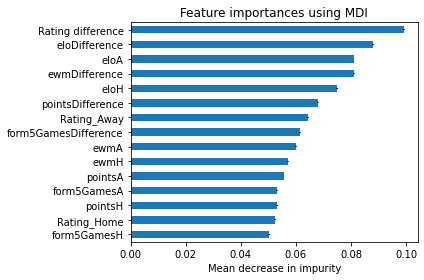

In [210]:

#feature_names = [f"feature {i}" for i in range(X.shape[1])]


forest_importances = pd.Series(importances, index=feature_names)
forest_importances= forest_importances.sort_values()
fig, ax = plt.subplots()


forest_importances.plot.barh( ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

In [388]:
#for measuring training time
from time import time
# F1 score (also F-score or F-measure) is a measure of a test's accuracy.
#It considers both the precision p and the recall r of the test to compute
#the score: p is the number of correct positive results divided by the number of
#all positive results, and r is the number of correct positive results divided by
#the number of positive results that should have been returned. The F1 score can be
#interpreted as a weighted average of the precision and recall, where an F1 score
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''

    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()

    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))


def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''

    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)

    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))

    return f1_score(target, y_pred, average='weighted'),sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''

    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))

    # Train the classifier
    train_classifier(clf, X_train, y_train)

    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [225]:
train_predict(xgb_model, X_train, y_train, X_test, y_test)
print ('')
train_predict(rf_model, X_train, y_train, X_test, y_test)

Training a XGBClassifier using a training set size of 304. . .
Trained model in 0.3911 seconds
Made predictions in 0.0156 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0000 seconds.
F1 score and accuracy score for test set: 0.4669 , 0.4737.

Training a RandomForestClassifier using a training set size of 304. . .
Trained model in 0.2512 seconds
Made predictions in 0.0317 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0156 seconds.
F1 score and accuracy score for test set: 0.3832 , 0.3816.


In [334]:
def calculate_elo():
    eloH = []
    eloA = []
    for index, row in PL_21_team_ratings.iterrows():
        eloH.append(eloLeague.ratingDict.get(row['HomeTeam']))
        eloA.append(eloLeague.ratingDict.get(row['AwayTeam']))
        if row['FTR'] == 'H':
            eloLeague.gameOver(winner= row['HomeTeam'], loser=row['AwayTeam'], winnerHome=True)
        elif row['FTR'] == 'A':
            eloLeague.gameOver(winner=row['AwayTeam'], loser=row['HomeTeam'], winnerHome=False)
    PL_21_team_ratings['eloH'] = eloH
    PL_21_team_ratings['eloA'] = eloA
calculate_elo()
PL_21_team_ratings

,Div,Date_x,Time_x,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,form3GamesDifference,form5GamesH,form5GamesA,form5GamesDifference,form7GamesH,form7GamesA,form7GamesDifference,identifier,eloH,eloA
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,0,0,0,0,0,0,0,1,1500.000000,1500.000000
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,0,0,0,0,0,0,0,0,1500.000000,1500.000000
2,E0,2020-09-12,17:30,Liverpool,Leeds United,4,3,H,3,2,...,0,0,0,0,0,0,0,0,1500.000000,1500.000000
3,E0,2020-09-12,20:00,West Ham,Newcastle Utd,0,2,A,0,0,...,0,0,0,0,0,0,0,1,1500.000000,1500.000000
4,E0,2020-09-13,14:00,West Brom,Leicester City,0,3,A,0,0,...,0,0,0,0,0,0,0,1,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,2021-05-23,16:00,Liverpool,Crystal Palace,2,0,H,1,0,...,3,13,6,7,17,6,11,0,1572.195622,1458.109252
376,E0,2021-05-23,16:00,Manchester City,Everton,5,0,H,2,0,...,-3,9,9,0,12,11,1,0,1629.646004,1521.033816
377,E0,2021-05-23,16:00,Sheffield Utd,Burnley,1,0,H,1,0,...,0,6,6,0,6,6,0,0,1362.194200,1452.510491
378,E0,2021-05-23,16:00,West Ham,Southampton,3,0,H,2,0,...,1,7,4,3,10,7,3,0,1551.974233,1441.808453
